# SQL in Python - Connecting to and retrieving data from PostgreSQL

Previously, you have learned how to connect to a SQL database by using a SQL client such as DBeaver. Apart from connecting to databases, DBeaver also allows you to run SQL queries against the database, create new tables and populate them with data as well as retrieving the data.

Python also allows executing SQL queries and getting the result into a Python object, for example a Pandas data frame. Instead of exporting a .csv file from DBeaver you can directly get the data you need into Python and continue your work. In addition we can reduce the steps by connecting to the database from Python directly, eliminating the need for a separate SQL client.

After you have the data in Python in the required shape you can export the data into a .csv file. This file is for your own reference, please avoid sending .csv files around - database is the point of reference when it comes to data. 

Having a copy of a .csv file (or another format) can speed up your analysis work. Imagine that the query takes 25 minutes to run. If you made some mistakes in your Python code you might need to go back to the original dataset. Instead of having to rerun the SQL query and having to wait you can read in the .csv file you have previously saved on your hard disk into Python and continue with your analysis work. 

**In this notebook you will see 2 ways to connect to SQL-Databases and export the data to a CSV file**


## Creating a connection to a PostgreSQL database with Python

There are 2 python packages that are the "go-to" when it comes to connecting to SQL-Databases: `psycopg2` and `sqlalchemy` 

### Connecting via psycopg2

In [1]:
import pandas as pd
import psycopg2


In order to create a connection to our PostgreSQL database we need the following information:

- host = the address of the machine the database is hosted on
- port = the virtual gate number through which communication will be allowed
- database = the name of the database
- user = the name of the user
- password = the password of the user

Because we don't want that the database information is published on github we put it into a `.env` file which is added into the `.gitignore`. 
In these kind of files you can store information that is not supposed to be published.
With the `dotenv` package you can read the `.env` files and get the variables.
(We will share the file with you on Slack!)


In [8]:
import os
from dotenv import load_dotenv

load_dotenv()

DATABASE = os.getenv('postgres')
USER_DB = os.getenv('aipm230625')
PASSWORD = os.getenv('mialovesicecream')
HOST = os.getenv('ds-sql-playground.c8g8r1deus2v.eu-central-1.rds.amazonaws.com')
PORT = os.getenv('5432')

The function from the psycopg2 package to create a connection is called `connect()`.
`connect()` expects the parameters listed above as input in order to connect to the database.

In [24]:
# Create connection object conn
conn = psycopg2.connect(
    database="postgres",
    user="aipm230625",
    password="mialovesicecream",
    host="ds-sql-playground.c8g8r1deus2v.eu-central-1.rds.amazonaws.com",
    port=5432
    
)


### Retrieving data from the database with psycopg2

Before we can use our connection to get data, we have to create a cursor. A cursor allows Python code to execute PostgreSQL commmands in a database session.
A cursor has to be created with the `cursor()` method of our connection object conn.

In [25]:
cur = conn.cursor()

Now we can run SQL-Queries with `cur.execute('QUERY')` and then run `cur.fetchall()` to get the data:

In [26]:
cur.execute('SELECT * FROM eda.king_county_house_sales LIMIT 10')
cur.fetchall()

[(datetime.date(2014, 10, 13), 221900.0, 7129300520, 1),
 (datetime.date(2014, 12, 9), 538000.0, 6414100192, 2),
 (datetime.date(2015, 2, 25), 180000.0, 5631500400, 3),
 (datetime.date(2014, 12, 9), 604000.0, 2487200875, 4),
 (datetime.date(2015, 2, 18), 510000.0, 1954400510, 5),
 (datetime.date(2014, 5, 12), 1230000.0, 7237550310, 6),
 (datetime.date(2014, 6, 27), 257500.0, 1321400060, 7),
 (datetime.date(2015, 1, 15), 291850.0, 2008000270, 8),
 (datetime.date(2015, 4, 15), 229500.0, 2414600126, 9),
 (datetime.date(2015, 3, 12), 323000.0, 3793500160, 10)]

With `conn.close()` you can close the connection again.

In [27]:
#close the connection
conn.close()

But we want to work with the data. The easiest way is to import the data into pandas dataframes. We can use `pd.read_sql_query` or `pd.read_sql_table` or for convenience `pd.read_sql`.

This function is a convenience wrapper around read_sql_table and read_sql_query (for backward compatibility). It will delegate to the specific function depending on the provided input. A SQL query will be routed to read_sql_query , while a database table name will be routed to read_sql_table . Note that the delegated function might have more specific notes about their functionality not listed here.

In [29]:
# Open connection again because we closed it
conn = psycopg2.connect(
    database="postgres",
    user="aipm230625",
    password="mialovesicecream",
    host="ds-sql-playground.c8g8r1deus2v.eu-central-1.rds.amazonaws.com",
    port=5432
    
)

In [30]:
# import the data into a pandas dataframe
query_string = "SELECT * FROM eda.king_county_house_sales LIMIT 10"
df_psycopg = pd.read_sql(query_string, conn)

/var/folders/xp/1_yfjf054zn1nswnmhndxymh0000gn/T/ipykernel_42862/1176423828.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_psycopg = pd.read_sql(query_string, conn)


In [31]:
#close the connection
conn.close()

In [32]:
df_psycopg.head()

,date,price,house_id,id
0,2014-10-13,221900.0,7129300520,1
1,2014-12-09,538000.0,6414100192,2
2,2015-02-25,180000.0,5631500400,3
3,2014-12-09,604000.0,2487200875,4
4,2015-02-18,510000.0,1954400510,5


In [17]:
#export the data to a csv-file
df_psycopg.to_csv('data/eda.csv',index=False)

### Connecting and retrieving data via SQLAlchemy

`sqlalchemy` works similarly. Here you have to create an engine with the database sting (a link that includes every information we entered in the conn object)

In [53]:
from sqlalchemy import create_engine

#read the database string from the .env
load_dotenv()

DB_STRING = os.getenv('DB_STRING')

db = create_engine(DB_STRING)

And then you can import that engine with a query into a pandas dataframe.

In [86]:
#import the data to a pandas dataframe
query_string = """
SELECT
    s.id          AS sale_id,
    s.house_id,
    s.date        AS sale_date,
    s.price,
    d.bedrooms,
    d.bathrooms,
    d.sqft_living,
    d.sqft_lot,
    d.waterfront,
    d.condition,
    d.grade,
    d.yr_built,
    d.yr_renovated,
    d.zipcode,
    d.sqft_living15,
    d.sqft_lot15
FROM eda.king_county_house_details d
JOIN eda.king_county_house_sales s ON s.house_id = d.id;
"""

df = pd.read_sql(query_string, db)
df.head()



,sale_id,house_id,sale_date,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,condition,grade,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
0,1,7129300520,2014-10-13,221900.0,3.0,1.00,1180.0,5650.0,NaN,3,7,1955,0.0,98178,1340.0,5650.0
1,2,6414100192,2014-12-09,538000.0,3.0,2.25,2570.0,7242.0,0.0,3,7,1951,19910.0,98125,1690.0,7639.0
2,3,5631500400,2015-02-25,180000.0,2.0,1.00,770.0,10000.0,0.0,3,6,1933,NaN,98028,2720.0,8062.0
3,4,2487200875,2014-12-09,604000.0,4.0,3.00,1960.0,5000.0,0.0,5,7,1965,0.0,98136,1360.0,5000.0
4,5,1954400510,2015-02-18,510000.0,3.0,2.00,1680.0,8080.0,0.0,3,8,1987,0.0,98074,1800.0,7503.0


In [71]:
df.info()
df.isnull().sum()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sale_id        21597 non-null  int64  
 1   house_id       21597 non-null  int64  
 2   sale_date      21597 non-null  object 
 3   price          21597 non-null  float64
 4   bedrooms       21597 non-null  float64
 5   bathrooms      21597 non-null  float64
 6   sqft_living    21597 non-null  float64
 7   sqft_lot       21597 non-null  float64
 8   waterfront     19206 non-null  float64
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  yr_built       21597 non-null  int64  
 12  yr_renovated   17749 non-null  float64
 13  zipcode        21597 non-null  int64  
 14  sqft_living15  21597 non-null  float64
dtypes: float64(8), int64(6), object(1)
memory usage: 2.5+ MB


sale_id             0
house_id            0
sale_date           0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
waterfront       2391
condition           0
grade               0
yr_built            0
yr_renovated     3848
zipcode             0
sqft_living15       0
dtype: int64

In [72]:
df1= df[df['waterfront'] == 0]


In [73]:
df1.isnull().sum()

sale_id             0
house_id            0
sale_date           0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
waterfront          0
condition           0
grade               0
yr_built            0
yr_renovated     3389
zipcode             0
sqft_living15       0
dtype: int64

In [74]:
df1 = df1[df1['bathrooms'] >= 4]



In [75]:
df1['bathrooms'].min()


np.float64(4.0)

In [76]:
df1.shape


(340, 15)

In [58]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 19060 entries, 1 to 21596
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sale_id       19060 non-null  int64  
 1   house_id      19060 non-null  int64  
 2   sale_date     19060 non-null  object 
 3   price         19060 non-null  float64
 4   bedrooms      19060 non-null  float64
 5   bathrooms     19060 non-null  float64
 6   sqft_living   19060 non-null  float64
 7   sqft_lot      19060 non-null  float64
 8   waterfront    19060 non-null  float64
 9   condition     19060 non-null  int64  
 10  grade         19060 non-null  int64  
 11  yr_built      19060 non-null  int64  
 12  yr_renovated  15671 non-null  float64
 13  zipcode       19060 non-null  int64  
dtypes: float64(7), int64(6), object(1)
memory usage: 2.2+ MB


In [77]:
df_bath = df[df['waterfront'] == 0]
df_bath = df_bath[df_bath['bathrooms'] >= 4]


In [78]:
zipcodes_target = df_bath['zipcode'].unique()


In [79]:
nearby_zipcodes = set()

for z in zipcodes_target:
    nearby_zipcodes.update([z-2, z-1, z, z+1, z+2])


In [80]:
df['zipcode'] = df['zipcode'].astype(int)


In [81]:
df_small = df[
    (df['waterfront'] == 0) &
    (df['sqft_living'] < 1500) &
    (df['zipcode'].isin(nearby_zipcodes))
]


In [82]:
df1 = pd.concat([df_bath, df_small]).drop_duplicates()


In [83]:
df1.shape


(5551, 15)

In [84]:
df1['yr_built'].median()


np.float64(1958.0)

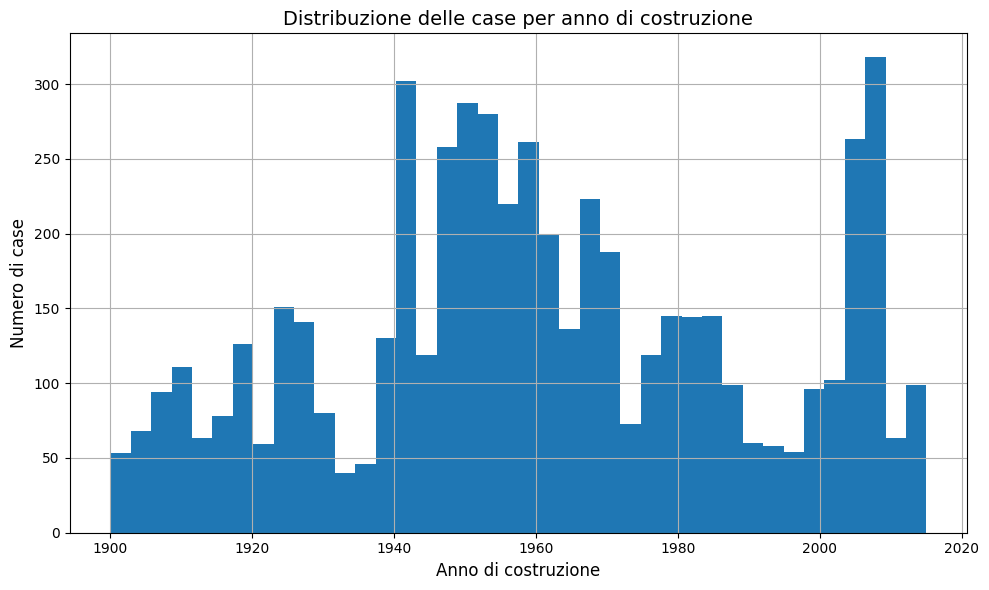

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
df1['yr_built'].hist(bins=40)

plt.xlabel("Anno di costruzione", fontsize=12)
plt.ylabel("Numero di case", fontsize=12)
plt.title("Distribuzione delle case per anno di costruzione", fontsize=14)
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

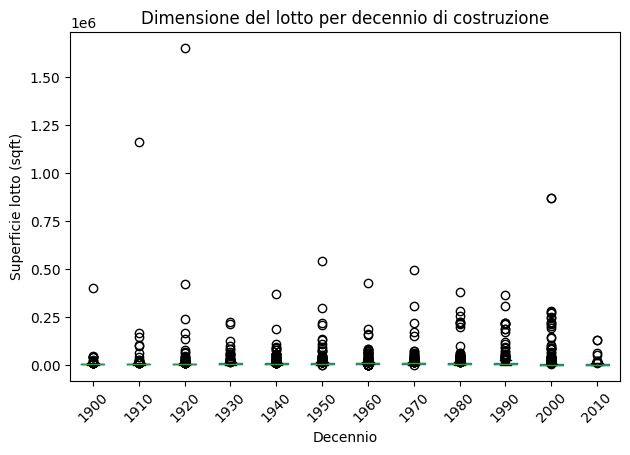

In [87]:
df1['decade'] = (df1['yr_built'] // 10) * 10

plt.figure(figsize=(12,6))
df1.boxplot(column='sqft_lot', by='decade', grid=False)
plt.title("Dimensione del lotto per decennio di costruzione")
plt.suptitle("")
plt.xlabel("Decennio")
plt.ylabel("Superficie lotto (sqft)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


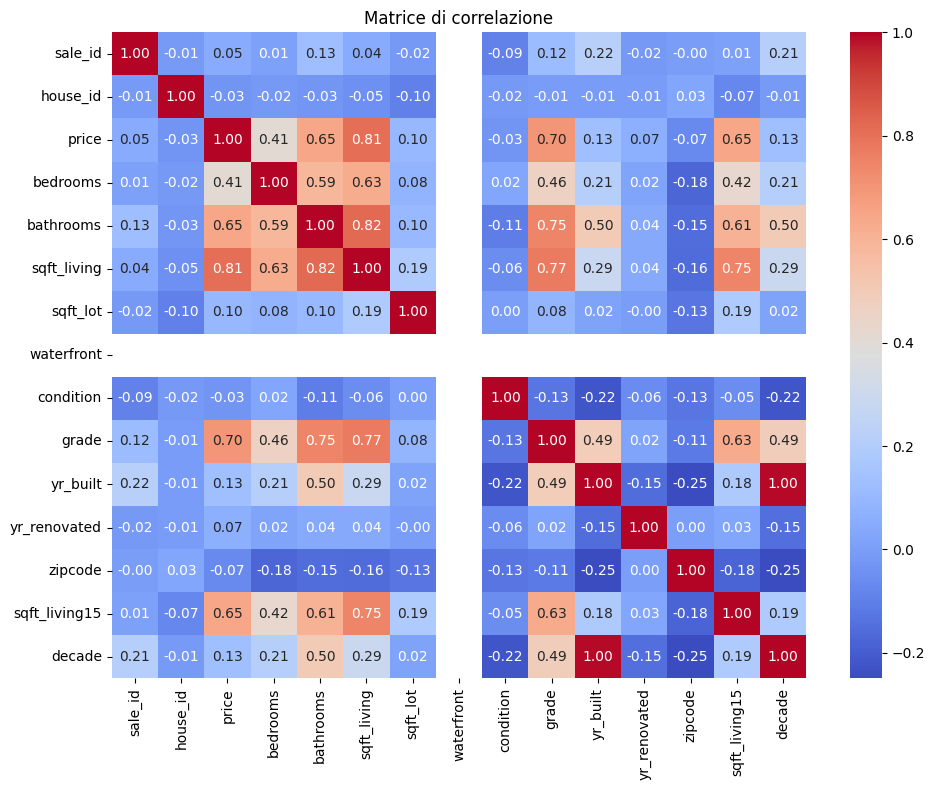

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(df1.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice di correlazione")
plt.tight_layout()
plt.show()


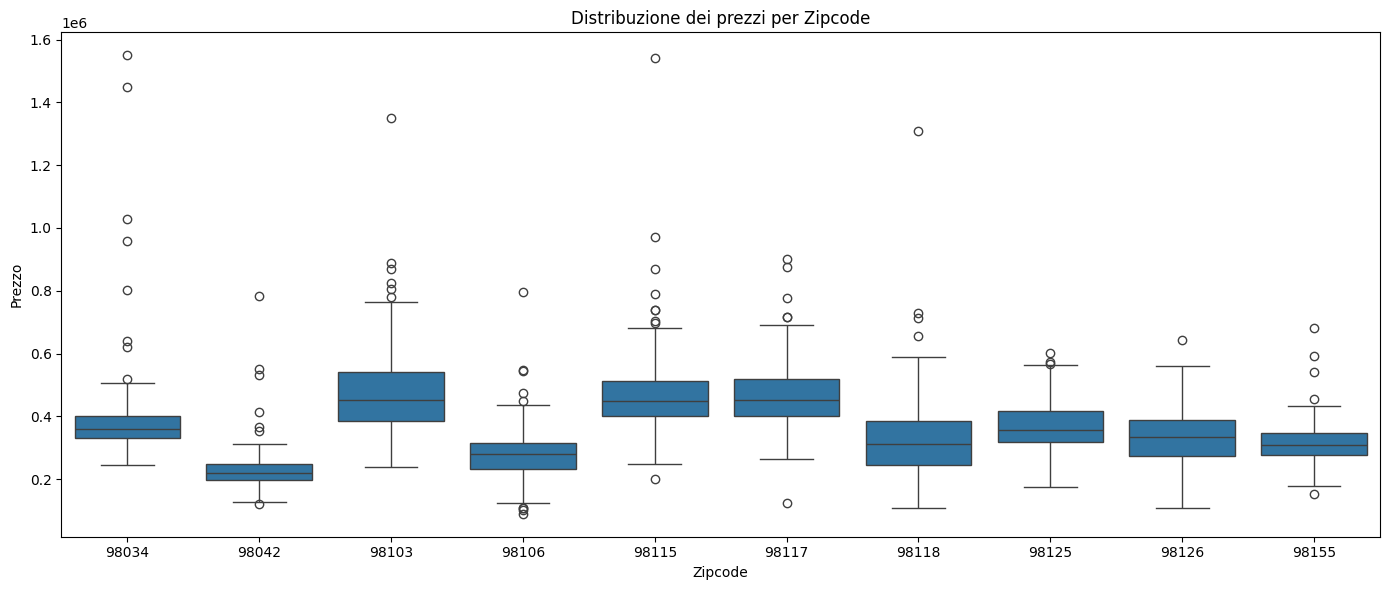

In [90]:
plt.figure(figsize=(14,6))
top_zipcodes = df1['zipcode'].value_counts().head(10).index  # solo i 10 più frequenti

sns.boxplot(data=df1[df1['zipcode'].isin(top_zipcodes)], x='zipcode', y='price')
plt.title("Distribuzione dei prezzi per Zipcode")
plt.xlabel("Zipcode")
plt.ylabel("Prezzo")
plt.tight_layout()
plt.show()



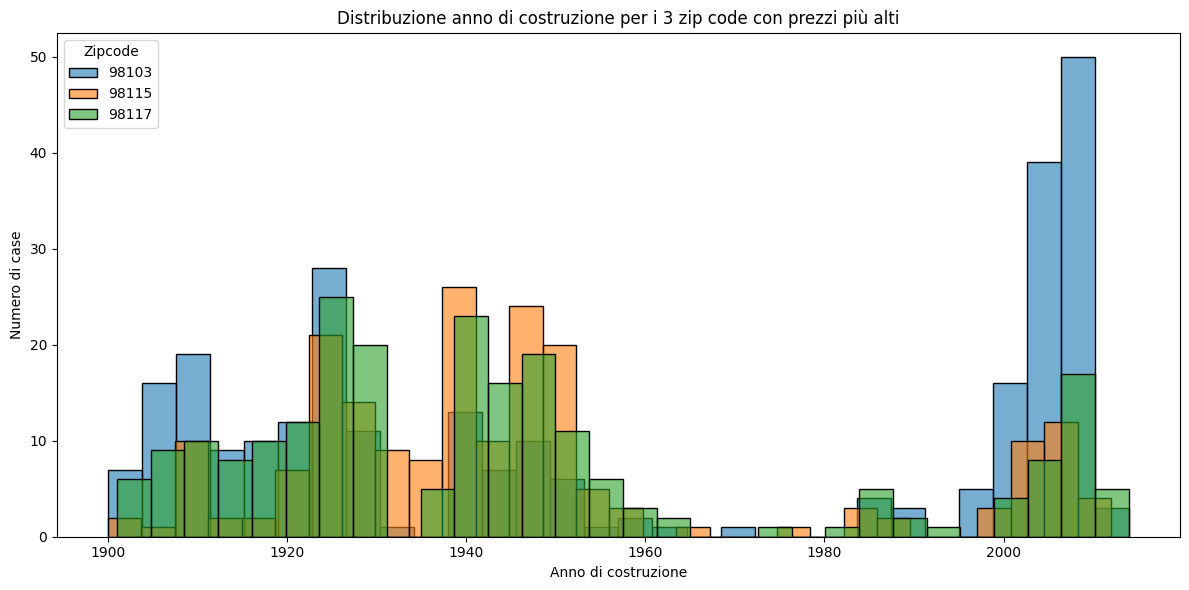

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

top_zipcodes = [98103, 98115, 98117]

plt.figure(figsize=(12,6))

for zipcode in top_zipcodes:
    subset = df1[df1['zipcode'] == zipcode]
    sns.histplot(subset['yr_built'], bins=30, kde=False, label=str(zipcode), alpha=0.6)

plt.legend(title="Zipcode")
plt.xlabel("Anno di costruzione")
plt.ylabel("Numero di case")
plt.title("Distribuzione anno di costruzione per i 3 zip code con prezzi più alti")
plt.tight_layout()
plt.show()


In [93]:
df_filtered = df1[df1['sqft_lot'] >= df1['sqft_lot'].quantile(0.75)]


In [95]:
df_filtered.shape

(1388, 16)

In [96]:
df_filtered.head()

,sale_id,house_id,sale_date,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,condition,grade,yr_built,yr_renovated,zipcode,sqft_living15,decade
5,6,7237550310,2014-05-12,1230000.0,4.0,4.50,5420.0,101930.0,0.0,3,11,2001,0.0,98053,4760.0,2000
75,76,3276920270,2014-11-05,832500.0,4.0,4.00,3430.0,35102.0,0.0,4,10,1986,0.0,98075,3240.0,1980
235,236,1762600320,2014-06-10,1030000.0,5.0,4.00,3760.0,28040.0,0.0,3,10,1983,0.0,98033,3430.0,1980
270,271,4054500390,2014-10-07,1370000.0,4.0,4.75,5310.0,57346.0,0.0,4,11,1989,NaN,98077,4180.0,1980
419,420,8678500060,2014-07-10,1550000.0,5.0,4.25,6070.0,171626.0,0.0,3,12,1999,0.0,98024,4680.0,1990


In [ ]:
# comtrollo la relazione tra sqft_lot e anno di construzione

In [97]:
storiche = df1[df1['yr_built'] < 1950]
moderne = df1[df1['yr_built'] >= 1950]


In [98]:
print("Mediana lotto (storiche):", storiche['sqft_lot'].median())
print("Mediana lotto (moderne):", moderne['sqft_lot'].median())

print("Media lotto (storiche):", storiche['sqft_lot'].mean())
print("Media lotto (moderne):", moderne['sqft_lot'].mean())


Mediana lotto (storiche): 5750.0
Mediana lotto (moderne): 7651.0
Media lotto (storiche): 10560.517910447761
Media lotto (moderne): 12502.018921208699


/var/folders/xp/1_yfjf054zn1nswnmhndxymh0000gn/T/ipykernel_42862/774561258.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df1, x='epoca', y='sqft_lot', palette='Set2')


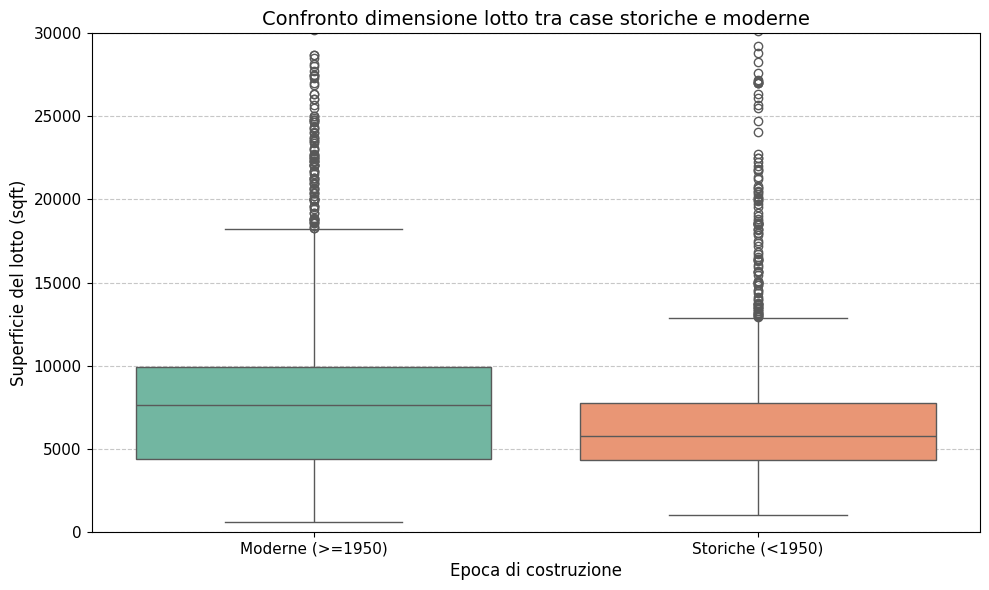

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggiunta della colonna 'epoca' se non esiste
df1['epoca'] = df1['yr_built'].apply(lambda x: 'Storiche (<1950)' if x < 1950 else 'Moderne (>=1950)')

plt.figure(figsize=(10, 6))
sns.boxplot(data=df1, x='epoca', y='sqft_lot', palette='Set2')

plt.ylim(0, 30000)  # Limita l’asse Y per evitare valori estremi
plt.title("Confronto dimensione lotto tra case storiche e moderne", fontsize=14)
plt.xlabel("Epoca di costruzione", fontsize=12)
plt.ylabel("Superficie del lotto (sqft)", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



In [101]:
# Crea colonna per identificare case storiche
df_filtered['storica'] = df_filtered['yr_built'] < 1950

# Crea colonna per identificare se la casa è stata rinnovata
df_filtered['rinnovata'] = df_filtered['yr_renovated'] > 0

# Tabella incrociata: storica sì/no vs. rinnovata sì/no
pd.crosstab(df_filtered['storica'], df_filtered['rinnovata'], margins=True)


/var/folders/xp/1_yfjf054zn1nswnmhndxymh0000gn/T/ipykernel_42862/2233812762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['storica'] = df_filtered['yr_built'] < 1950
/var/folders/xp/1_yfjf054zn1nswnmhndxymh0000gn/T/ipykernel_42862/2233812762.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['rinnovata'] = df_filtered['yr_renovated'] > 0


rinnovata,False,True,All
storica,,,
False,1072,24,1096
True,269,23,292
All,1341,47,1388


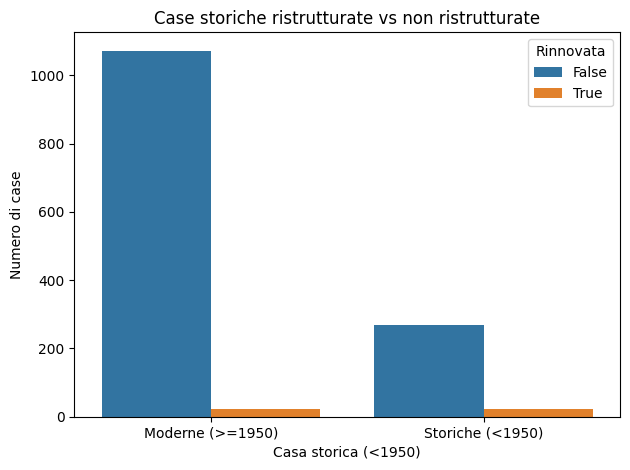

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df_filtered, x='storica', hue='rinnovata')
plt.xlabel("Casa storica (<1950)")
plt.ylabel("Numero di case")
plt.title("Case storiche ristrutturate vs non ristrutturate")
plt.xticks([0,1], ['Moderne (>=1950)', 'Storiche (<1950)'])
plt.legend(title="Rinnovata")
plt.tight_layout()
plt.show()


In [ ]:
# - escludo le case rinnovate
df_filtered = df_filtered[(df_filtered['yr_renovated'] == 0) | (df_filtered['yr_renovated'].isna())]


In [104]:
df_filtered.shape 

(1341, 18)

/var/folders/xp/1_yfjf054zn1nswnmhndxymh0000gn/T/ipykernel_42862/1892396304.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=storiche_zip.index.astype(str), y=storiche_zip.values, palette='Set2')


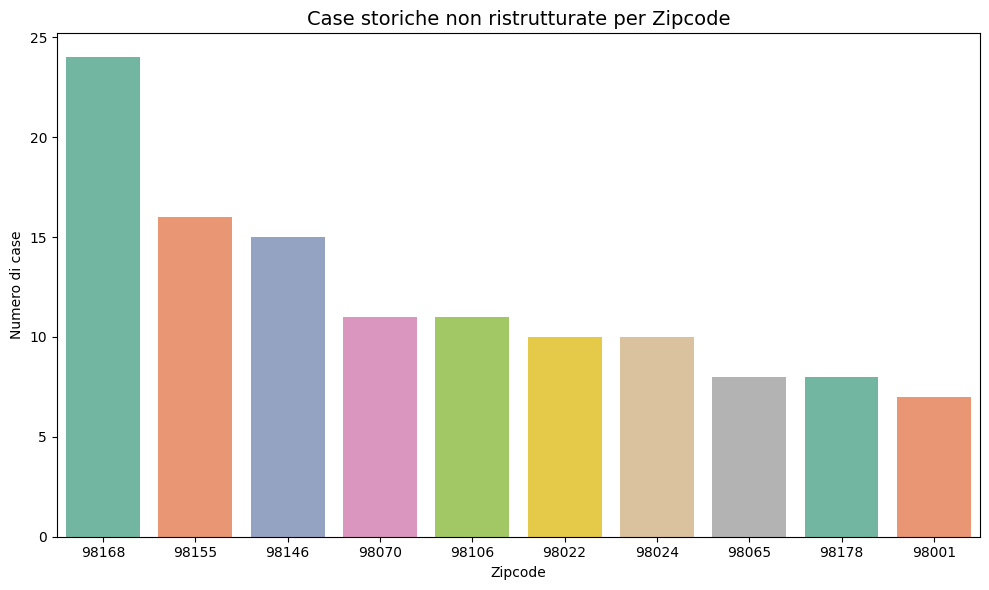

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtra solo le case storiche non ristrutturate (<1950)
df_storiche = df_filtered[df_filtered['yr_built'] < 1950]

# Conta quante per ogni zipcode
storiche_zip = df_storiche['zipcode'].value_counts().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=storiche_zip.index.astype(str), y=storiche_zip.values, palette='Set2')

plt.title("Case storiche non ristrutturate per Zipcode", fontsize=14)
plt.xlabel("Zipcode")
plt.ylabel("Numero di case")
plt.tight_layout()
plt.show()

# --> 

Le case storiche non ristrutturate sono rare e distribuite in zone selezionate


Le case storiche non ristrutturate sono rare e distribuite in zone selezionate


In [48]:
df.describe()


,sale_id,house_id,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,condition,grade,yr_built,yr_renovated,zipcode
count,21597.000000,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,19206.000000,21597.000000,21597.000000,21597.000000,17749.000000,21597.000000
mean,10799.000000,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,0.007602,3.409825,7.657915,1970.999676,836.650516,98077.951845
std,6234.661218,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.086858,0.650546,1.173200,29.375234,4000.110554,53.513072
min,1.000000,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,0.000000,1.000000,3.000000,1900.000000,0.000000,98001.000000
25%,5400.000000,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,0.000000,3.000000,7.000000,1951.000000,0.000000,98033.000000
50%,10799.000000,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,0.000000,3.000000,7.000000,1975.000000,0.000000,98065.000000
75%,16198.000000,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,0.000000,4.000000,8.000000,1997.000000,0.000000,98118.000000
max,21597.000000,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,1.000000,5.000000,13.000000,2015.000000,20150.000000,98199.000000


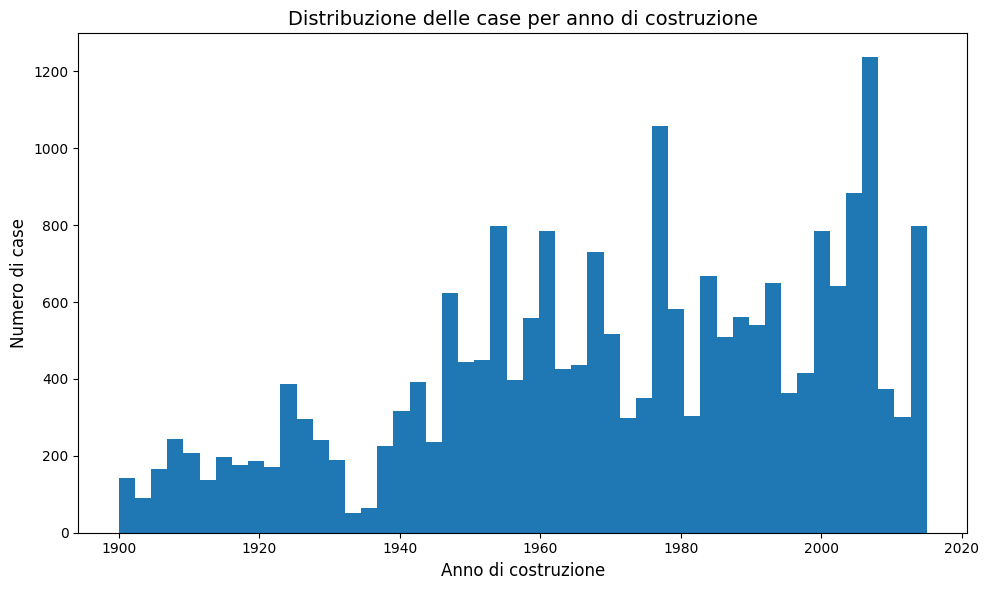

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
df['yr_built'].hist(bins=50)

plt.xlabel("Anno di costruzione", fontsize=12)
plt.ylabel("Numero di case", fontsize=12)
plt.title("Distribuzione delle case per anno di costruzione", fontsize=14)
plt.grid(False)  # opzionale, puoi metterlo True se preferisci
plt.tight_layout()
plt.show()




In [37]:
df_sqlalchemy.head()

,date,price,house_id,id
0,2014-10-13,221900.0,7129300520,1
1,2014-12-09,538000.0,6414100192,2
2,2015-02-25,180000.0,5631500400,3
3,2014-12-09,604000.0,2487200875,4
4,2015-02-18,510000.0,1954400510,5


Because we don't want to run the queries over and over again we can export the data into a .csv file in order to use it in other notebooks as well. 

In [ ]:
#export the data to a csv-file
df_sqlalchemy.to_csv('eda.csv',index=False)

In [18]:
#import the data from a csv-file
df_import = pd.read_csv('data/eda.csv')